In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 1000
NUM_KEYPOINTS = 13 * 2  # 24 pairs each having x and y coordinates

In [3]:
IMG_DIR = "../img"
JSON = "annotation.json"

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Load the metdata definition file and preview it.
keypoint_def = json_data["meta"]["task"]["labels"]

# Extract the colours and labels.
colours = list(map(lambda x: x["color"], keypoint_def))
labels = list(map(lambda x: x["name"], keypoint_def))
    
# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
def modify_points(ob):
    ob["points"] = sorted(ob["points"], key=lambda x: labels.index(x["label"]))
    ob["points"] = list(map(lambda x: [float(x["points"].split(',')[0]), float(x["points"].split(',')[1])]
                            ,ob["points"]))
    return ob
json_dict = {i["name"]: modify_points(i) for i in json_data["image"]}

In [4]:
# Utility for reading an image and for getting its annotations.
def get_img(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["name"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

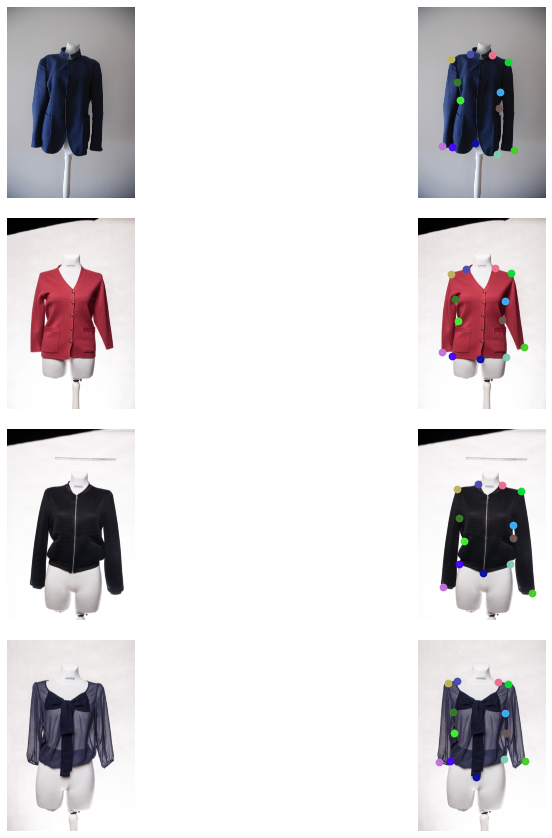

In [5]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            for idx, el in enumerate(current_keypoint):
                ax_all.scatter(el[0], el[1], c=colours[idx], marker=".", s=30, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_img(sample)
    image = data["img_data"]
    keypoint = data["points"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)


In [6]:
selected_samples

array(['J004.jpg', 'IMG_9408.jpg', 'IMG_9321.jpg', 'IMG_9419.jpg'],
      dtype='<U111')

In [7]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_img(key)
            current_keypoint = np.array(data["points"])
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)
            #print(kps_obj)
            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            #print(new_kps_obj)
            #print(new_image.shape)
            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))
            #print(kp_temp)
            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 13 * 2)
        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)


In [11]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [9]:
len(samples)

64

In [12]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)


Total batches in training set: 6
Total batches in validation set: 1


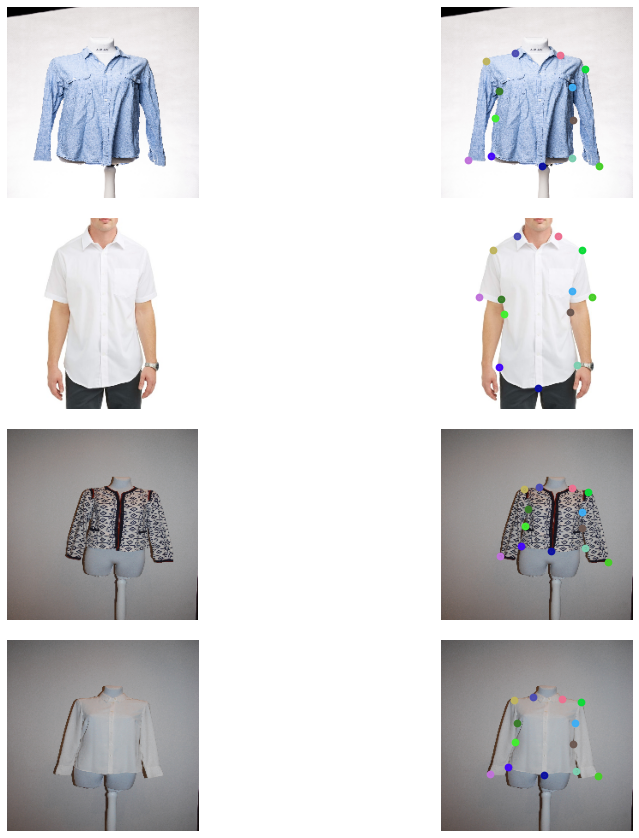

In [13]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

assert sample_keypoints.max() <= 1.0
assert sample_keypoints.min() >= 0.0
sample_keypoints = sample_keypoints[:4].reshape(-1, 13, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)


In [14]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


In [15]:
get_model().summary()


Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                 

In [16]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)


Epoch 1/1000
6/6 [==============================] - 13s 1s/step - loss: 0.0486 - val_loss: 0.0448
Epoch 2/1000
6/6 [==============================] - 6s 991ms/step - loss: 0.0485 - val_loss: 0.0441
Epoch 3/1000
6/6 [==============================] - 6s 960ms/step - loss: 0.0488 - val_loss: 0.0435
Epoch 4/1000
6/6 [==============================] - 6s 952ms/step - loss: 0.0463 - val_loss: 0.0427
Epoch 5/1000
6/6 [==============================] - 6s 954ms/step - loss: 0.0468 - val_loss: 0.0419
Epoch 6/1000
6/6 [==============================] - 6s 980ms/step - loss: 0.0456 - val_loss: 0.0410
Epoch 7/1000
6/6 [==============================] - 6s 950ms/step - loss: 0.0458 - val_loss: 0.0401
Epoch 8/1000
6/6 [==============================] - 6s 957ms/step - loss: 0.0435 - val_loss: 0.0392
Epoch 9/1000
6/6 [==============================] - 6s 939ms/step - loss: 0.0435 - val_loss: 0.0381
Epoch 10/1000
6/6 [==============================] - 6s 957ms/step - loss: 0.0430 - val_loss: 0.0371
E

6/6 [==============================] - 7s 1s/step - loss: 0.0200 - val_loss: 0.0097
Epoch 84/1000
6/6 [==============================] - 6s 971ms/step - loss: 0.0182 - val_loss: 0.0094
Epoch 85/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0188 - val_loss: 0.0091
Epoch 86/1000
6/6 [==============================] - 6s 981ms/step - loss: 0.0234 - val_loss: 0.0091
Epoch 87/1000
6/6 [==============================] - 6s 963ms/step - loss: 0.0231 - val_loss: 0.0095
Epoch 88/1000
6/6 [==============================] - 6s 985ms/step - loss: 0.0232 - val_loss: 0.0100
Epoch 89/1000
6/6 [==============================] - 6s 999ms/step - loss: 0.0193 - val_loss: 0.0103
Epoch 90/1000
6/6 [==============================] - 6s 940ms/step - loss: 0.0205 - val_loss: 0.0106
Epoch 91/1000
6/6 [==============================] - 6s 963ms/step - loss: 0.0197 - val_loss: 0.0105
Epoch 92/1000
6/6 [==============================] - 6s 955ms/step - loss: 0.0181 - val_loss: 0.0100
Epoch 93/1

6/6 [==============================] - 6s 1s/step - loss: 0.0071 - val_loss: 0.0065
Epoch 166/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0115 - val_loss: 0.0068
Epoch 167/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0110 - val_loss: 0.0071
Epoch 168/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0138 - val_loss: 0.0078
Epoch 169/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0093 - val_loss: 0.0080
Epoch 170/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0105 - val_loss: 0.0077
Epoch 171/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0103 - val_loss: 0.0073
Epoch 172/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0093 - val_loss: 0.0068
Epoch 173/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0086 - val_loss: 0.0069
Epoch 174/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0061 - val_loss: 0.0064
Epoch 175/1000
6/6 [=====

6/6 [==============================] - 6s 1s/step - loss: 0.0051 - val_loss: 0.0060
Epoch 247/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0034 - val_loss: 0.0055
Epoch 248/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0031 - val_loss: 0.0051
Epoch 249/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0037 - val_loss: 0.0051
Epoch 250/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0046 - val_loss: 0.0056
Epoch 251/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0037 - val_loss: 0.0060
Epoch 252/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0032 - val_loss: 0.0060
Epoch 253/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0044 - val_loss: 0.0058
Epoch 254/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0044 - val_loss: 0.0062
Epoch 255/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0048 - val_loss: 0.0062
Epoch 256/1000
6/6 [=====

Epoch 329/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0024 - val_loss: 0.0059
Epoch 330/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0022 - val_loss: 0.0059
Epoch 331/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0019 - val_loss: 0.0060
Epoch 332/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0024 - val_loss: 0.0061
Epoch 333/1000
6/6 [==============================] - 9s 2s/step - loss: 0.0026 - val_loss: 0.0060
Epoch 334/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0019 - val_loss: 0.0056
Epoch 335/1000
6/6 [==============================] - 10s 2s/step - loss: 0.0024 - val_loss: 0.0057
Epoch 336/1000
6/6 [==============================] - 9s 1s/step - loss: 0.0028 - val_loss: 0.0063
Epoch 337/1000
6/6 [==============================] - 10s 2s/step - loss: 0.0018 - val_loss: 0.0063
Epoch 338/1000
6/6 [==============================] - 9s 2s/step - loss: 0.0020 - val_loss: 0.0059
Epoch 33

6/6 [==============================] - 8s 1s/step - loss: 0.0014 - val_loss: 0.0059
Epoch 412/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0020 - val_loss: 0.0059
Epoch 413/1000
6/6 [==============================] - 9s 2s/step - loss: 0.0015 - val_loss: 0.0067
Epoch 414/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0015 - val_loss: 0.0069
Epoch 415/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0018 - val_loss: 0.0064
Epoch 416/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0015 - val_loss: 0.0063
Epoch 417/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0016 - val_loss: 0.0058
Epoch 418/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0013 - val_loss: 0.0057
Epoch 419/1000
6/6 [==============================] - 9s 1s/step - loss: 0.0012 - val_loss: 0.0061
Epoch 420/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0013 - val_loss: 0.0064
Epoch 421/1000
6/6 [=====

6/6 [==============================] - 6s 1s/step - loss: 0.0012 - val_loss: 0.0055
Epoch 494/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0010 - val_loss: 0.0054
Epoch 495/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0011 - val_loss: 0.0056
Epoch 496/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0011 - val_loss: 0.0063
Epoch 497/1000
6/6 [==============================] - 6s 1s/step - loss: 9.9339e-04 - val_loss: 0.0062
Epoch 498/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0012 - val_loss: 0.0060
Epoch 499/1000
6/6 [==============================] - 6s 1s/step - loss: 8.9720e-04 - val_loss: 0.0059
Epoch 500/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0010 - val_loss: 0.0058
Epoch 501/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0012 - val_loss: 0.0054
Epoch 502/1000
6/6 [==============================] - 6s 1s/step - loss: 8.0529e-04 - val_loss: 0.0054
Epoch 503/100

6/6 [==============================] - 6s 991ms/step - loss: 9.1742e-04 - val_loss: 0.0058
Epoch 574/1000
6/6 [==============================] - 6s 981ms/step - loss: 8.6505e-04 - val_loss: 0.0063
Epoch 575/1000
6/6 [==============================] - 6s 942ms/step - loss: 9.4802e-04 - val_loss: 0.0062
Epoch 576/1000
6/6 [==============================] - 6s 938ms/step - loss: 9.8483e-04 - val_loss: 0.0055
Epoch 577/1000
6/6 [==============================] - 6s 993ms/step - loss: 9.7036e-04 - val_loss: 0.0056
Epoch 578/1000
6/6 [==============================] - 6s 963ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 579/1000
6/6 [==============================] - 6s 1s/step - loss: 0.0010 - val_loss: 0.0064
Epoch 580/1000
6/6 [==============================] - 6s 1000ms/step - loss: 9.2735e-04 - val_loss: 0.0073
Epoch 581/1000
6/6 [==============================] - 6s 956ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 582/1000
6/6 [==============================] - 6s 1s/step - loss: 0.

6/6 [==============================] - 6s 1s/step - loss: 7.2858e-04 - val_loss: 0.0066
Epoch 652/1000
6/6 [==============================] - 6s 1s/step - loss: 7.2017e-04 - val_loss: 0.0062
Epoch 653/1000
6/6 [==============================] - 6s 954ms/step - loss: 7.9774e-04 - val_loss: 0.0065
Epoch 654/1000
6/6 [==============================] - 6s 957ms/step - loss: 8.4199e-04 - val_loss: 0.0070
Epoch 655/1000
6/6 [==============================] - 6s 981ms/step - loss: 8.2145e-04 - val_loss: 0.0067
Epoch 656/1000
6/6 [==============================] - 6s 1s/step - loss: 8.1216e-04 - val_loss: 0.0058
Epoch 657/1000
6/6 [==============================] - 6s 951ms/step - loss: 9.1026e-04 - val_loss: 0.0056
Epoch 658/1000
6/6 [==============================] - 6s 955ms/step - loss: 8.9340e-04 - val_loss: 0.0066
Epoch 659/1000
6/6 [==============================] - 6s 945ms/step - loss: 0.0010 - val_loss: 0.0066
Epoch 660/1000
6/6 [==============================] - 6s 1s/step - loss: 7

6/6 [==============================] - 6s 996ms/step - loss: 8.5504e-04 - val_loss: 0.0068
Epoch 730/1000
6/6 [==============================] - 6s 940ms/step - loss: 6.6947e-04 - val_loss: 0.0063
Epoch 731/1000
6/6 [==============================] - 6s 1s/step - loss: 7.2721e-04 - val_loss: 0.0057
Epoch 732/1000
6/6 [==============================] - 6s 1s/step - loss: 6.4942e-04 - val_loss: 0.0059
Epoch 733/1000
6/6 [==============================] - 6s 1s/step - loss: 6.4565e-04 - val_loss: 0.0062
Epoch 734/1000
6/6 [==============================] - 6s 980ms/step - loss: 6.5416e-04 - val_loss: 0.0057
Epoch 735/1000
6/6 [==============================] - 6s 950ms/step - loss: 6.2621e-04 - val_loss: 0.0052
Epoch 736/1000
6/6 [==============================] - 6s 934ms/step - loss: 7.6574e-04 - val_loss: 0.0056
Epoch 737/1000
6/6 [==============================] - 6s 977ms/step - loss: 7.0285e-04 - val_loss: 0.0058
Epoch 738/1000
6/6 [==============================] - 6s 982ms/step - 

6/6 [==============================] - 6s 999ms/step - loss: 8.0404e-04 - val_loss: 0.0070
Epoch 808/1000
6/6 [==============================] - 6s 987ms/step - loss: 6.9235e-04 - val_loss: 0.0071
Epoch 809/1000
6/6 [==============================] - 6s 978ms/step - loss: 6.4102e-04 - val_loss: 0.0069
Epoch 810/1000
6/6 [==============================] - 6s 1s/step - loss: 5.4213e-04 - val_loss: 0.0065
Epoch 811/1000
6/6 [==============================] - 6s 989ms/step - loss: 7.8246e-04 - val_loss: 0.0068
Epoch 812/1000
6/6 [==============================] - 6s 1s/step - loss: 6.1911e-04 - val_loss: 0.0064
Epoch 813/1000
6/6 [==============================] - 6s 974ms/step - loss: 5.7597e-04 - val_loss: 0.0065
Epoch 814/1000
6/6 [==============================] - 6s 990ms/step - loss: 5.3105e-04 - val_loss: 0.0062
Epoch 815/1000
6/6 [==============================] - 6s 1s/step - loss: 7.2496e-04 - val_loss: 0.0063
Epoch 816/1000
6/6 [==============================] - 6s 1s/step - los

6/6 [==============================] - 6s 1s/step - loss: 6.9728e-04 - val_loss: 0.0055
Epoch 886/1000
6/6 [==============================] - 6s 968ms/step - loss: 5.7447e-04 - val_loss: 0.0063
Epoch 887/1000
6/6 [==============================] - 6s 1s/step - loss: 5.9438e-04 - val_loss: 0.0063
Epoch 888/1000
6/6 [==============================] - 6s 1s/step - loss: 6.3029e-04 - val_loss: 0.0063
Epoch 889/1000
6/6 [==============================] - 6s 1s/step - loss: 7.0534e-04 - val_loss: 0.0066
Epoch 890/1000
6/6 [==============================] - 6s 1s/step - loss: 6.0320e-04 - val_loss: 0.0062
Epoch 891/1000
6/6 [==============================] - 6s 1s/step - loss: 5.9069e-04 - val_loss: 0.0065
Epoch 892/1000
6/6 [==============================] - 6s 1s/step - loss: 5.2310e-04 - val_loss: 0.0068
Epoch 893/1000
6/6 [==============================] - 6s 1s/step - loss: 6.7136e-04 - val_loss: 0.0062
Epoch 894/1000
6/6 [==============================] - 6s 990ms/step - loss: 6.1766e-0

6/6 [==============================] - 7s 1s/step - loss: 6.5378e-04 - val_loss: 0.0061
Epoch 965/1000
6/6 [==============================] - 7s 1s/step - loss: 5.5807e-04 - val_loss: 0.0064
Epoch 966/1000
6/6 [==============================] - 7s 1s/step - loss: 5.8354e-04 - val_loss: 0.0055
Epoch 967/1000
6/6 [==============================] - 8s 1s/step - loss: 6.0919e-04 - val_loss: 0.0058
Epoch 968/1000
6/6 [==============================] - 7s 1s/step - loss: 6.0224e-04 - val_loss: 0.0073
Epoch 969/1000
6/6 [==============================] - 7s 1s/step - loss: 6.2917e-04 - val_loss: 0.0070
Epoch 970/1000
6/6 [==============================] - 7s 1s/step - loss: 5.9312e-04 - val_loss: 0.0059
Epoch 971/1000
6/6 [==============================] - 8s 1s/step - loss: 5.8782e-04 - val_loss: 0.0058
Epoch 972/1000
6/6 [==============================] - 10s 2s/step - loss: 5.9090e-04 - val_loss: 0.0062
Epoch 973/1000
6/6 [==============================] - 8s 1s/step - loss: 5.2844e-04 - v

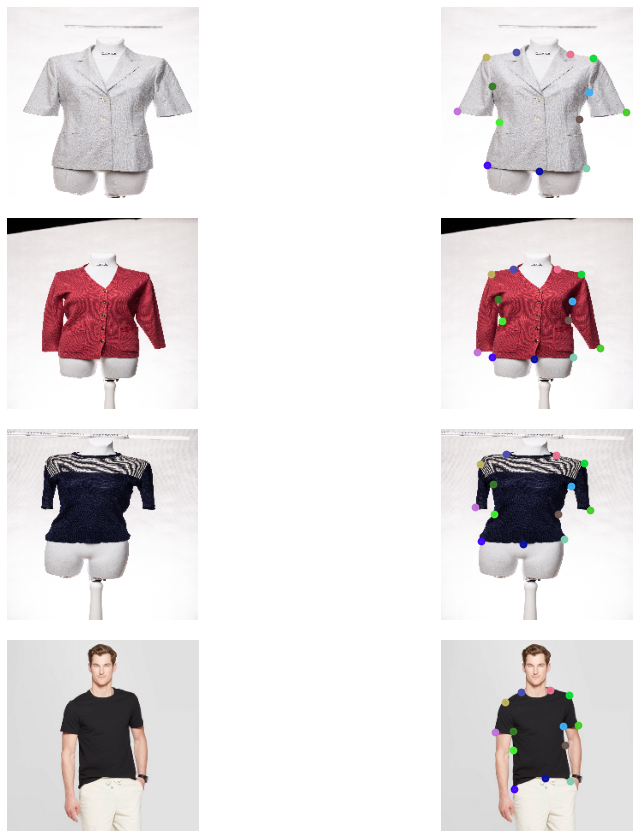

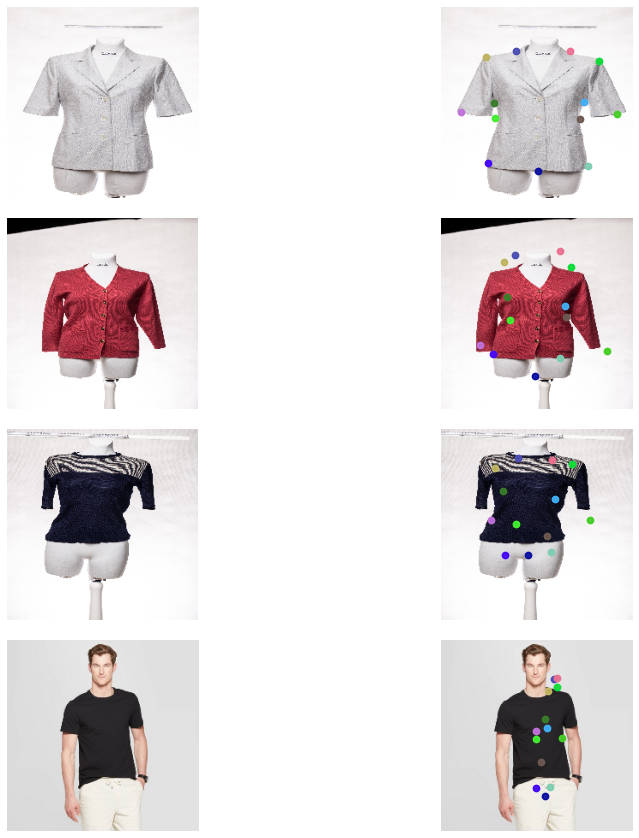

In [17]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 13, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 13, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)
